In [2]:
import os
import cv2  # You might need to install OpenCV: pip install opencv-python
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers,optimizers
from sklearn.metrics import r2_score,mean_squared_error

LOADING THE DATASET FOLDER

In [3]:
data_dir = 'affectnet'  # Replace with your dataset folder path
image_size = (64, 64)  # Adjust the image size as needed

CREATING THE EMPTY ARRAYS FOR LATER APPENDING

In [4]:
images = []
labels = []
train_images=[]
train_labels=[]
val_images=[]
val_labels=[]

FILTERING THE IMAGES BASED ON THE FILE NAME INTO PARTICULAR CLASSES AND THEN SPLITTING THE DATASET INTO TRAINING AND TESTING SAMPLES 

In [5]:
for image_name in os.listdir(data_dir):
    image_path = os.path.join(data_dir, image_name)
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_size)
    images.append(image)
    labels.append(int(image_name.split('_')[11][-1]))  # Extracting the class number from the filename
    if 'train' in image_name:
        train_images.append(image)
        train_labels.append(int(image_name.split('_')[11][-1])-1)
    elif 'val' in image_name:
        val_images.append(image)
        val_labels.append(int(image_name.split('_')[11][-1])-1)

CONVERTING SAMPLES INTO NUMPY ARRAY

In [6]:
val_labels = np.array(val_labels)
train_labels = np.array(train_labels)
train_images = np.array(train_images)
val_images = np.array(val_images)

In [7]:
print(np.unique(val_labels))
print(np.unique(train_labels))

[0 1 2 3 4 5 6]
[0 1 2 3 4 5 6]


In [8]:
print(np.unique(val_labels))

[0 1 2 3 4 5 6]


NORMALIZING THE SAMPLES

In [9]:
train_images=train_images/255.0
val_images=val_images/255.0

Define the Residual Block

In [10]:
def residual_block(x, filters, kernel_size=3, strides=1):
    res = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    res = BatchNormalization()(res)
    res = Activation('relu')(res)

    res = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(res)
    res = BatchNormalization()(res)

    x = Add()([x, res])
    x = Activation('relu')(x)
    return x

Define the ResNet model with L2 regularization

In [11]:
def resnet_regularized(input_shape, num_classes):
    input = Input(shape=input_shape)
    
    x = Conv2D(64, (7, 7), strides=2, padding='same', kernel_regularizer=regularizers.l2(0.01))(input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)
    
    x = residual_block(x, filters=64)
    x = residual_block(x, filters=64)
    x = MaxPooling2D((3, 3), strides=2, padding='same')(x)
    
    x = GlobalAveragePooling2D()(x)
    output = Dense(num_classes, activation='softmax', kernel_regularizer=regularizers.l2(0.01))(x)

    model = Model(inputs=input, outputs=output)
    return model

ONE HOT ENCODING 

In [12]:
train_labels_categorical = to_categorical(train_labels, num_classes=7)
val_labels_categorical = to_categorical(val_labels, num_classes=7)

Define input shape and number of classes

In [13]:
input_shape = (64, 64, 3)  # Modify this according to your image size
num_classes = 7  # Replace this with the number of classes in your dataset

Instantiate the model

In [14]:
model_regularized = resnet_regularized(input_shape, num_classes)
model_regularized.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 32, 32, 64)           9472      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 32, 32, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 32, 32, 64)           0         ['batch_normalization[0][0

Compile the model

In [15]:
model_regularized.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

Train the model

In [16]:
history = model_regularized.fit(train_images, train_labels_categorical, validation_data=(val_images, val_labels_categorical), epochs=50, batch_size=32, shuffle=True)

Epoch 1/50
889/889 [==============================] - 204s 221ms/step - loss: 2.0152 - accuracy: 0.2436 - val_loss: 2.3021 - val_accuracy: 0.2230
Epoch 2/50
889/889 [==============================] - 185s 208ms/step - loss: 1.7605 - accuracy: 0.3492 - val_loss: 2.2780 - val_accuracy: 0.1839
Epoch 3/50
889/889 [==============================] - 193s 217ms/step - loss: 1.6365 - accuracy: 0.3982 - val_loss: 2.3852 - val_accuracy: 0.2377
Epoch 4/50
889/889 [==============================] - 182s 204ms/step - loss: 1.5644 - accuracy: 0.4278 - val_loss: 1.7299 - val_accuracy: 0.3644
Epoch 5/50
889/889 [==============================] - 172s 194ms/step - loss: 1.5167 - accuracy: 0.4469 - val_loss: 1.7471 - val_accuracy: 0.3718
Epoch 6/50
889/889 [==============================] - 176s 198ms/step - loss: 1.4725 - accuracy: 0.4653 - val_loss: 1.6801 - val_accuracy: 0.3755
Epoch 7/50
889/889 [==============================] - 182s 205ms/step - loss: 1.4400 - accuracy: 0.4773 - val_loss: 1.6323 -

Get the training history                                                                                     
Plot training and validation accuracy                                                                                     
Plot training and validation loss

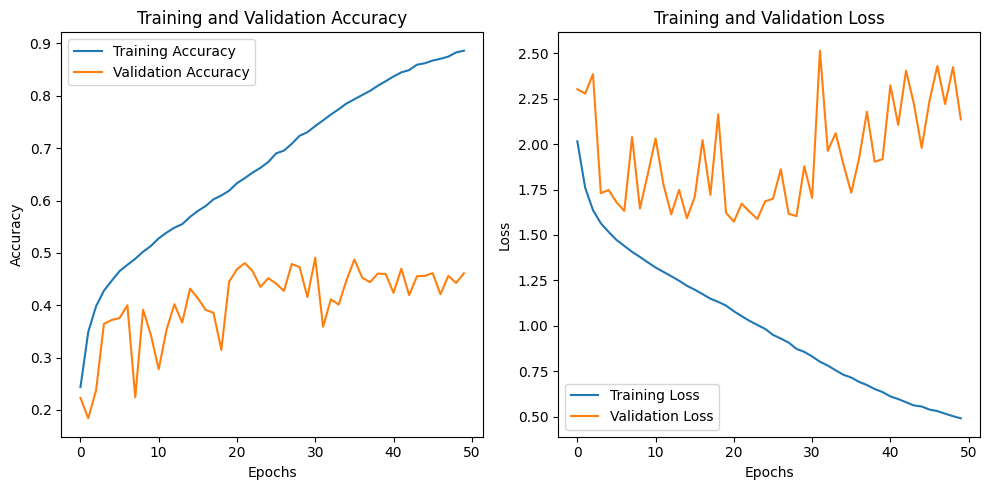

In [17]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.subplot(1, 2, 2)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Evaluate the model

In [18]:
loss, accuracy = model_regularized.evaluate(val_images, val_labels_categorical)
print(f"Validation Accuracy: {accuracy}")

94/94 [==============================] - 4s 42ms/step - loss: 2.1360 - accuracy: 0.4610
Validation Accuracy: 0.4610498249530792


MAKING THE PREDICTIONS

In [19]:
predictions = model_regularized.predict(val_images)  # Get predictions for the validation set

94/94 [==============================] - 5s 48ms/step


PRINTING THE MSE VALUE

In [20]:
mse = mean_squared_error(val_labels_categorical, predictions)  # Calculate the Mean Squared Error
print(f"Mean Squared Error (MSE): {mse}")
r2 = r2_score(val_labels_categorical, predictions)  # Calculate the Mean Squared Error
print(f"(R2): {r2}")

Mean Squared Error (MSE): 0.11110322177410126
(R2): 0.09178336824510411


DISPLAYING THE CONFUSION MATRIX

94/94 [==============================] - 4s 45ms/step


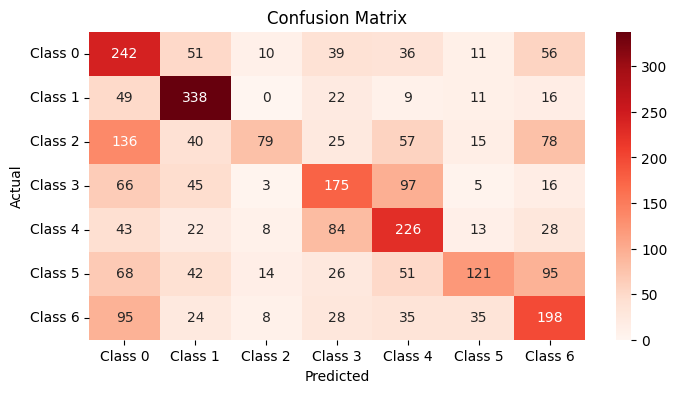

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Assuming 'predictions' are the model's predictions on validation data
predictions = model_regularized.predict(val_images)
# Convert predictions to class labels (assuming one-hot encoded predictions)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes (assuming 'val_labels' is in one-hot encoded form)
true_classes = np.argmax(val_labels_categorical, axis=1)

# Create the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Display the confusion matrix as a heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Reds', 
            xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6'], 
            yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4', 'Class 5', 'Class 6'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()